In [53]:
# !pip install torch
# !pip install torchvision

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [75]:
class FCVAE(nn.Module):
    def __init__(self, input_dim=12288, hidden_dim=1000, latent_dim=128):
        super(FCVAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)

        self.fc_mu = nn.Linear(hidden_dim * 4, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 4, latent_dim)

        # Latent to hidden
        self.z_fc = nn.Linear(latent_dim, hidden_dim * 4)
        
        # Decoder
        self.fc4 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc5 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        return self.fc_mu(h3), torch.clamp(self.fc_logvar(h3), min=-20, max=20)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.z_fc(z))
        h = torch.relu(self.fc4(h))
        h = torch.relu(self.fc5(h))
        x_recon = torch.sigmoid(self.fc6(h))
        return x_recon.view(-1, 3, 32, 32)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [56]:
# Conv VAE Architecture
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(256)

        self.conv_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.conv_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        self.z = nn.Linear(latent_dim, 256 * 4 * 4)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.debatch_norm1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.debatch_norm2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.debatch_norm3 = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)

        self.leaky_relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.leaky_relu(self.batch_norm1(self.conv1(x)))
        x = self.leaky_relu(self.batch_norm2(self.conv2(x)))
        x = self.leaky_relu(self.batch_norm3(self.conv3(x)))
        x = self.leaky_relu(self.batch_norm4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.z(z)
        x = x.view(-1, 256, 4, 4)
        x = self.leaky_relu(self.debatch_norm1(self.deconv1(x)))
        x = self.leaky_relu(self.debatch_norm2(self.deconv2(x)))
        x = self.leaky_relu(self.debatch_norm3(self.deconv3(x)))
        x = self.tanh(self.deconv4(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [70]:
# Loss function
def loss_function(recon_x, x, mu, logvar, beta=0.0001):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD, MSE, KLD

In [58]:
# Training the VAE
def train(model, train_loader, optimizer, epoch, num_epochs, model_name, device):
    model.train()
    train_loss_total = 0
    recon_loss_total = 0
    kld_loss_total = 0
    with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}', colour='green') as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            if model_name == 'cvae':
                data = data.to(device)
            elif model_name == 'fcvae':
                data = data.view(data.size(0), -1).to(device)   
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            if model_name == 'fcvae':
                recon_batch = recon_batch.view(data.size(0), -1)
                data = data.view(data.size(0), -1)
            total_loss, recon_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
            total_loss.backward()
            train_loss_total += total_loss.item()
            recon_loss_total += recon_loss.item()
            kld_loss_total += kld_loss.item()
            optimizer.step()
            tepoch.set_postfix(
                train_loss=train_loss_total / len(train_loader.dataset),
                recon_loss=recon_loss_total / len(train_loader.dataset),
                kld_loss=kld_loss_total / len(train_loader.dataset)
            )
    print(f'Epoch {epoch}/{num_epochs} train loss: {train_loss_total / len(train_loader.dataset)} mse loss: {recon_loss_total / len(train_loader.dataset)} kld loss: {kld_loss_total / len(train_loader.dataset)}')

In [59]:
num_epochs = 10
lr = 1e-3

In [60]:
# Train the CVAE
transform_cvae = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset_cvae = datasets.CelebA('./data2/cvae', split='train', download=True, transform=transform_cvae)
train_loader_cvae = torch.utils.data.DataLoader(train_dataset_cvae, batch_size=128, shuffle=True)

cvae = ConvVAE(latent_dim=128).to(device)
optimizer_cvae = optim.Adam(cvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(cvae, train_loader_cvae, optimizer_cvae, epoch, num_epochs, 'cvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 1272/1272 [10:21<00:00,  2.05batch/s, kld_loss=8.45e+3, recon_loss=662, train_loss=670]


Epoch 1/10 train loss: 670.0097970631489 mse loss: 661.5616849599895 kld loss: 8448.111354905923


Epoch 2: 100%|██████████| 1272/1272 [09:32<00:00,  2.22batch/s, kld_loss=1.57e+3, recon_loss=327, train_loss=329]


Epoch 2/10 train loss: 328.63212720834997 mse loss: 327.06020806294924 kld loss: 1571.9188722967992


Epoch 3: 100%|██████████| 1272/1272 [09:31<00:00,  2.22batch/s, kld_loss=1.83e+3, recon_loss=280, train_loss=282]


Epoch 3/10 train loss: 282.0363741062926 mse loss: 280.20889094850094 kld loss: 1827.4829935453402


Epoch 4: 100%|██████████| 1272/1272 [09:53<00:00,  2.14batch/s, kld_loss=2.06e+3, recon_loss=265, train_loss=267]


Epoch 4/10 train loss: 267.1078226274037 mse loss: 265.04794130521594 kld loss: 2059.8815258877557


Epoch 5: 100%|██████████| 1272/1272 [09:58<00:00,  2.13batch/s, kld_loss=2.18e+3, recon_loss=255, train_loss=258]


Epoch 5/10 train loss: 257.5613699425378 mse loss: 255.37739629490616 kld loss: 2183.9734906808685


Epoch 6: 100%|██████████| 1272/1272 [09:45<00:00,  2.17batch/s, kld_loss=2.22e+3, recon_loss=250, train_loss=252]


Epoch 6/10 train loss: 252.3522419719927 mse loss: 250.13341991623534 kld loss: 2218.821891223045


Epoch 7: 100%|██████████| 1272/1272 [09:43<00:00,  2.18batch/s, kld_loss=2.15e+3, recon_loss=244, train_loss=246]


Epoch 7/10 train loss: 246.15866200198133 mse loss: 244.00954355407555 kld loss: 2149.1182324944707


Epoch 8: 100%|██████████| 1272/1272 [09:35<00:00,  2.21batch/s, kld_loss=2.04e+3, recon_loss=240, train_loss=242]


Epoch 8/10 train loss: 241.86072920426446 mse loss: 239.82177107411917 kld loss: 2038.9580610293665


Epoch 9: 100%|██████████| 1272/1272 [09:34<00:00,  2.22batch/s, kld_loss=1.9e+3, recon_loss=237, train_loss=239] 


Epoch 9/10 train loss: 238.7262825084859 mse loss: 236.82293055384898 kld loss: 1903.3518939684832


Epoch 10: 100%|██████████| 1272/1272 [09:46<00:00,  2.17batch/s, kld_loss=1.79e+3, recon_loss=234, train_loss=236]

Epoch 10/10 train loss: 236.15080748045554 mse loss: 234.36138864943632 kld loss: 1789.4189234617866


In [76]:
# Train the FCVAE
transform_fcvae = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset_fcvae = datasets.CelebA('./data2/fcvae', split='train', download=True, transform=transform_fcvae)
train_loader_fcvae = torch.utils.data.DataLoader(train_dataset_fcvae, batch_size=128, shuffle=True)

fcvae = FCVAE(latent_dim=128).to(device)
optimizer_fcvae = optim.Adam(fcvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(fcvae, train_loader_fcvae, optimizer_fcvae, epoch, num_epochs, 'fcvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 1272/1272 [12:11<00:00,  1.74batch/s, kld_loss=4.28e+6, recon_loss=3.48e+3, train_loss=3.91e+3]


Epoch 1/10 train loss: 3911.8331456963815 mse loss: 3484.08131182036 kld loss: 4277518.587876521


Epoch 2: 100%|██████████| 1272/1272 [12:17<00:00,  1.72batch/s, kld_loss=613, recon_loss=3.22e+3, train_loss=3.22e+3]


Epoch 2/10 train loss: 3223.3668387525345 mse loss: 3223.305493564539 kld loss: 613.4392527367988


Epoch 3: 100%|██████████| 1272/1272 [12:29<00:00,  1.70batch/s, kld_loss=772, recon_loss=3.16e+3, train_loss=3.16e+3]


Epoch 3/10 train loss: 3163.220000902347 mse loss: 3163.1428340219327 kld loss: 771.6684108999663


Epoch 4: 100%|██████████| 1272/1272 [12:41<00:00,  1.67batch/s, kld_loss=837, recon_loss=3.14e+3, train_loss=3.14e+3]


Epoch 4/10 train loss: 3135.168312553757 mse loss: 3135.084617289734 kld loss: 836.9639892563126


Epoch 5: 100%|██████████| 1272/1272 [12:47<00:00,  1.66batch/s, kld_loss=854, recon_loss=3.12e+3, train_loss=3.12e+3]


Epoch 5/10 train loss: 3117.5854007956013 mse loss: 3117.5000395496713 kld loss: 853.6186237674326


Epoch 6: 100%|██████████| 1272/1272 [12:56<00:00,  1.64batch/s, kld_loss=854, recon_loss=3.1e+3, train_loss=3.1e+3]  


Epoch 6/10 train loss: 3101.846505421761 mse loss: 3101.761096178657 kld loss: 854.0764713053695


Epoch 7: 100%|██████████| 1272/1272 [13:57<00:00,  1.52batch/s, kld_loss=835, recon_loss=3.09e+3, train_loss=3.09e+3]


Epoch 7/10 train loss: 3089.8488496037353 mse loss: 3089.765363031425 kld loss: 834.8441840384438


Epoch 8: 100%|██████████| 1272/1272 [13:35<00:00,  1.56batch/s, kld_loss=834, recon_loss=3.08e+3, train_loss=3.08e+3]


Epoch 8/10 train loss: 3081.5426884945014 mse loss: 3081.4593055000923 kld loss: 833.805848743626


Epoch 9: 100%|██████████| 1272/1272 [13:24<00:00,  1.58batch/s, kld_loss=834, recon_loss=3.08e+3, train_loss=3.08e+3]


Epoch 9/10 train loss: 3075.2944343437057 mse loss: 3075.2110162153654 kld loss: 834.1525952071942


Epoch 10: 100%|██████████| 1272/1272 [13:30<00:00,  1.57batch/s, kld_loss=834, recon_loss=3.07e+3, train_loss=3.07e+3]

Epoch 10/10 train loss: 3069.7183395281686 mse loss: 3069.63490047306 kld loss: 834.3746001835412


In [77]:
# Function to generate and display new images
def generate_images(model, model_name, num_images, latent_dim):
    if np.sqrt(num_images) % 1 != 0:
        raise ValueError('num_images must be a perfect square')
    
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim).to(next(model.parameters()).device)
        # Decode these points to generate images
        generated_images = []
        for i in tqdm(range(num_images), desc='Generating images', unit='image', colour='blue'):
            generated_image = model.decode(z[i:i+1]).cpu()
            generated_images.append(generated_image)
    # Convert the generated images to a single tensor
    generated_images = torch.cat(generated_images, dim=0)

    if model_name == 'cvae':
        # Rescale the images to the range [-1, 1]
        generated_images = (generated_images + 1) / 2

    # Rescale the images to the range [0, 1]
    generated_images = torch.clamp(generated_images, 0, 1)

    grid_size = int(np.sqrt(num_images))

    # Plot the generated images
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size + 1, grid_size + 1))
    axs = axs.flatten() if len(axs.shape) == 2 else axs
    for i in range(num_images):
        axs[i].imshow(generated_images[i].numpy().transpose(1, 2, 0))
        axs[i].axis('off')
    plt.show()

Images from FC VAE


Generating images: 100%|██████████| 25/25 [00:00<00:00, 180.17image/s]


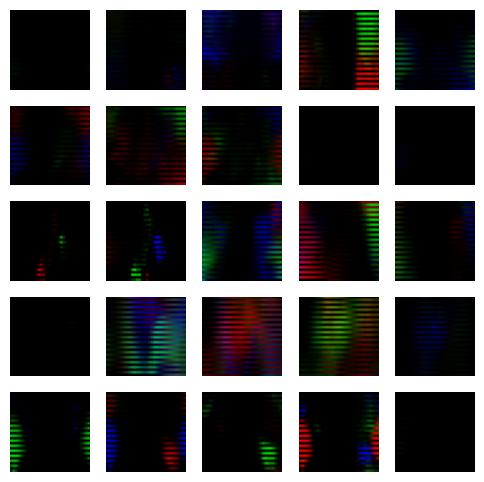

Images from Conv VAE


Generating images: 100%|██████████| 25/25 [00:00<00:00, 99.16image/s]


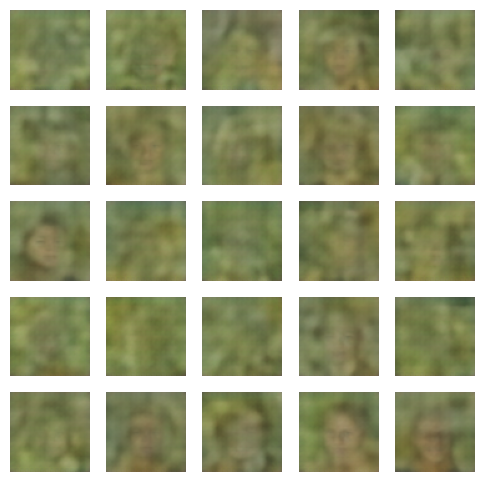

In [78]:
# Generate images
print('Images from FC VAE')
generate_images(fcvae, 'fcvae', num_images=25, latent_dim=128)

print('Images from Conv VAE')
generate_images(cvae, 'cvae', num_images=25, latent_dim=128)

In [79]:
# Function to interpolate between two images
def interpolate_images(model, model_name, image1, image2, device, num_steps=10):
    model.eval()
    with torch.no_grad():
        image1 = image1.to(device)
        image2 = image2.to(device)
        if model_name == 'fcvae':
            image1 = image1.view(-1, 3*32*32)
            image2 = image2.view(-1, 3*32*32)
        mu1, logvar1 = model.encode(image1.unsqueeze(0))
        mu2, logvar2 = model.encode(image2.unsqueeze(0))
        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)
        interpolated_images = []
        for alpha in np.linspace(0, 1, num_steps):
            interpolated_z = alpha * z1 + (1 - alpha) * z2
            reconstructed_image = model.decode(interpolated_z).cpu()
            interpolated_images.append(reconstructed_image)
            if model_name == 'cvae':
                reconstructed_image = (reconstructed_image + 1) / 2
        interpolated_images = torch.cat(interpolated_images, dim=0)
        return torch.clamp(interpolated_images, 0, 1)

In [80]:
def visualize_interpolation(model, model_name, dataset, num_steps=10):
    image1, _ = dataset[0]
    image2, _ = dataset[1]
    interpolated_images = interpolate_images(model, model_name, image1, image2, device, num_steps=num_steps)
    fig, axs = plt.subplots(1, num_steps, figsize=(num_steps, 1))
    for i in range(num_steps):
        axs[i].imshow(interpolated_images[i].numpy().transpose(1, 2, 0))
        axs[i].axis('off')
    plt.show()

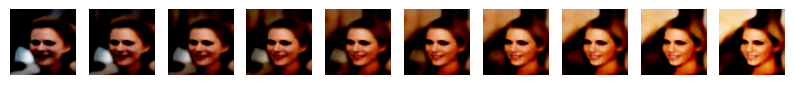

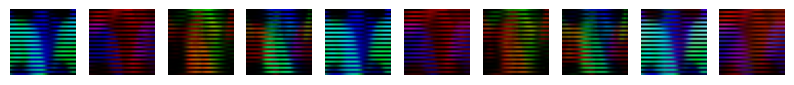

In [81]:
# Interpolate between two images from the dataset for Conv VAE
visualize_interpolation(cvae, 'cvae', train_dataset_cvae, num_steps=10)

# Interpolate between two images from the dataset for FC VAE
visualize_interpolation(fcvae, 'fcvae', train_dataset_fcvae, num_steps=10)